# Multi-armed Bandits for Component Permutations

### Dependencies

In [1]:
import os
import pandas as pd
import itertools
import seaborn
import math
from matplotlib import pyplot
from scipy import std, mean
from scipy.stats import mode, kurtosis, skew
from numpy import median
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import statistics
from pymc3.distributions.continuous import Normal
import pickle
from envs.data_handler import DataHandler
from tqdm.notebook import tqdm, trange

from algorithm_analysis.benchmark import BROKEN_COMPONENTS, BROKEN_COMPONENTS_NON_STATIONARY, \
    BROKEN_COMPONENTS_WEAK_STATIONARY
from algorithm_analysis.plotting import plot_episode_length_over_time_tabular, plot_episode_reward_over_time_tabular, scatter_episode_length_over_time_tabular, scatter_episode_reward_over_time_tabular
from envs.broken_components import BrokenComponentsEnv
import pickle

In [2]:
dh = DataHandler(data_generation='LinearShifted')
dh.data

Optimal_Affected_Component_Uid Optimal_Failure        raw
0           _SEwwu-cdEeet0YmmfbMwkw             CF1  1323.5038
1           _SExXgOcdEeet0YmmfbMwkw             CF2    26.2559
2           _SEx_HucdEeet0YmmfbMwkw             CF3    61.9029
3           _SEymDucdEeet0YmmfbMwkw             CF3    50.3732
4           _SExYKucdEeet0YmmfbMwkw             CF3    26.2599
...                             ...             ...        ...
2727        _SFSVwucdEeet0YmmfbMwkw             CF2     6.3610
2728        _SFSWy-cdEeet0YmmfbMwkw             CF1    26.4299
2729        _SFSW4ecdEeet0YmmfbMwkw             CF3    26.4249
2730        _SFSW7ecdEeet0YmmfbMwkw             CF2    10.5710
2731        _SFS8AOcdEeet0YmmfbMwkw             CF1     7.3920

[2732 rows x 3 columns]

### Multi-armed Bandit Class

In [30]:
def lazy_property(fn):
    '''Decorator that makes a property lazy-evaluated.'''
    attr_name = '_lazy_' + fn.__name__

    @property
    def _lazy_property(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, fn(self))
        return getattr(self, attr_name)
    return _lazy_property

class MultiArmedBandit:
    def __init__(self, no_of_actions=3, transform='raw', env='LinearShifted'):
        self.__env = env
        self.__transform = transform
        self.__non_stationary = env in ['ARol', 'GARCH']
        self.__data_handler = DataHandler(data_generation=self.__env, take_component_id='Optimal_Affected_Component')
        self.__actions = self.__data_handler.get_sample_component_failure_pairs(no_of_actions)
        self.__arms = list(itertools.permutations(self.actions))
        self.__number_of_arms = len(self.__arms)
        self.__reset_data_handler(self.__env)
        self.__arms_pulled = 0
    
    def __reset_data_handler(self, env):
        self.__data_handler = DataHandler(data_generation=self.__env, take_component_id='Optimal_Affected_Component')
        self.__true_mean_action_rewards = self.__compute_true_mean_action_rewards()
        self.__true_mean_arm_rewards = self.__compute_true_mean_arm_rewards()
        self.__true_optimal_arm = self.__compute_true_optimal_arm()
        self.__arms_pulled = 0

    def generate_new_actions(self):
        self.__actions = self.__data_handler.get_sample_component_failure_pairs(len(self.__actions))
        self.__arms = list(itertools.permutations(self.actions))
        self.__number_of_arms = len(self.__arms)
        self.__reset_data_handler(self.__env)

    @property
    def actions(self):
        return self.__actions

    @actions.setter
    def actions(self, value):
        self.__actions = value
        self.__arms = list(itertools.permutations(self.actions))
        self.__number_of_arms = len(self.__arms)
        self.__reset_data_handler(self.__env)
    
    @property
    def data(self):
        return self.__data_handler.data
    
    @property
    def arms(self):
        return self.__arms
    
    @property
    def true_mean_action_rewards(self):
        return self.__true_mean_action_rewards
    
    def __compute_true_mean_action_rewards(self):
        mean_action_rewards = []
        for action in self.actions:
            action_data = self.data.loc[(self.data['Optimal_Affected_Component_Uid'] == action[0]) & 
                                   (self.data['Optimal_Failure'] == action[1])]
            mean_action_rewards.append(action_data[self.__transform].mean(axis=0))
        return mean_action_rewards
    
    @property
    def number_of_arms(self):
        return self.__number_of_arms
    
    @property
    def true_mean_arm_rewards(self):
        return self.__true_mean_arm_rewards
    
    def __compute_true_mean_arm_rewards(self):
        rewards = []
        for arm_index in range(self.number_of_arms):
            rewards.append(self.true_mean_reward_for_arm(arm_index))
        return rewards
    
    @property
    def true_optimal_arm(self):
        return self.__true_optimal_arm
    
    def __compute_true_optimal_arm(self):
        # note that if there are several optimal arms, only the first is returned
        return self.true_mean_arm_rewards.index(max(self.true_mean_arm_rewards))
    
    def true_mean_reward_for_arm(self, arm_index=0):
        arm = self.arms[arm_index]
        total_time = len(arm)
        cumulative_reward = 0
        for action in arm:
            cumulative_reward += self.true_mean_action_rewards[self.actions.index(action)] * total_time #eol 
            total_time -= 1
        return cumulative_reward
    
    def pull_arm(self, arm_index=0):
        arm = self.arms[arm_index]
        total_time = len(arm)
        cumulative_reward = 0
        failing_components = list(arm)
        failed_to_fix_all_components = False
        for action in arm:
            action_reward = self.__data_handler.get_reward(action, failing_components)
            
            if action_reward == 0:
                failed_to_fix_all_components = True
                break
                
            failing_components.remove(action)
            cumulative_reward += action_reward * total_time
            total_time -= 1
        self.__arms_pulled += 1
        if self.__non_stationary and self.__arms_pulled >= 99:
            self.__reset_data_handler(self.__env)
        
        if failed_to_fix_all_components:
            return 0
        
        return cumulative_reward
    
    def reward_regret_optimal_for_arm(self, arm_index=0):
        reward = self.pull_arm(arm_index)
        optimal_reward = self.true_mean_arm_rewards[self.true_optimal_arm]
        regret = (optimal_reward - reward) / optimal_reward
        optimal = self.true_optimal_arm == arm_index
        return reward, regret, optimal
    
    def index_of_arm(self, arm):
        return self.arms.index(arm)
    


### Algorithm Classes

In [4]:
class BanditAlgorithm:
    def __init__(self, bandit):
        self.__bandit = bandit
        self.__name = ''
    
    @property
    def bandit(self):
        return self.__bandit
    
    def reward_regret_optimal(self):
        pass

    def reset(self):
        pass

    def new_bandit(self):
        self.__bandit = MultiArmedBandit

class EpsilonGreedy(BanditAlgorithm):
    def __init__(self, bandit, epsilon=0.3, decay=0.0):
        super().__init__(bandit)
        self.name = f'EpsilonGreedy (components:{len(bandit.actions)} epsilon:{epsilon} decay:{decay})'
        self.log = [[] for arm in self.bandit.arms]
        self.epsilon = epsilon
        self.decay = decay
        self.__initial_epsilon = epsilon

    def reset(self):
        self.__log = [[] for arm in self.bandit.arms]
        self.__epsilon = self.__initial_epsilon
    
    def log_is_empty(self):
        for entry in self.log:
            if entry: return False
        return True
    
    def reward_regret_optimal(self):
        arm = 0
        if random.random() <= self.epsilon or self.log_is_empty():
            arm = random.randrange(self.bandit.number_of_arms)
        else:
            means = [statistics.mean(entry) if entry else float('nan') for entry in self.log]
            arm = means.index(max(means))
        self.epsilon = self.epsilon * (1 - self.decay)
        reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
        self.log[arm].append(reward)
        return reward, regret, optimal

class UCBGreedy(BanditAlgorithm):
    def __init__(self, bandit, epsilon=0.3, decay=0.0, c_value=1):
        super().__init__(bandit)
        self.name = f'UCBGreedy (components:{len(bandit.actions)} epsilon:{epsilon} decay:{decay} c-value:{c_value})'
        self.__log = [[] for arm in self.bandit.arms]
        self.__epsilon = epsilon
        self.__decay = decay
        self.__initial_epsilon = epsilon
        self.__c_value = c_value

    def reset(self):
        self.__log = [[] for arm in self.bandit.arms]
        self.__epsilon = self.__initial_epsilon
    
    def log_is_empty(self):
        for entry in self.__log:
            if entry: return False
        return True
    
    def reward_regret_optimal(self):
        arm = 0
        if random.random() <= self.__epsilon or self.log_is_empty():
            arm = random.randrange(self.bandit.number_of_arms)
        else:
            iteration = sum(len(x) for x in self.__log)
            means = [statistics.mean(entry) if entry else float('nan') for entry in self.__log]
            upper_confidence_bounds = [means[index] + self.__c_value * math.sqrt((2*math.log(iteration+1))/len(self.__log[index])) if self.__log[index] else means[index] for index in range(len(means))]
            arm = upper_confidence_bounds.index(max(upper_confidence_bounds))
        self.__epsilon = self.__epsilon * (1 - self.__decay)
        reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
        self.__log[arm].append(reward)
        return reward, regret, optimal
    
class ThompsonSampling(BanditAlgorithm):
    def __init__(self, bandit, prior_mean=None, prior_variance=None, prior_variance_factor=1, true_variance=1, estimate_first=False):
        super().__init__(bandit)
        self.name = f'ThompsonSampling(components:{len(bandit.actions)} prior variance factor:{prior_variance_factor} true variance{true_variance} estimate first{estimate_first})'
        self.__norm_distr = [{} for arm in self.bandit.arms]
        self.__prior_variance_factor = prior_variance_factor
        self.__estimate_first = estimate_first

        self.__prior_mean = prior_mean
        self.__true_variance = true_variance
        self.__prior_variance = prior_variance


        self.__initial_prior_mean = prior_mean
        self.__initial_true_variance = true_variance
        self.__initial_prior_variance = prior_variance
    
    def reset(self):
        self.__norm_distr = [{} for arm in self.bandit.arms]
        self.__prior_mean = self.__initial_prior_mean
        self.__true_variance = self.__initial_true_variance
        self.__prior_variance = self.__initial_prior_variance

    def log_is_empty(self):
        for entry in self.__norm_distr:
            if entry: return False
        return True
    
    def pick_arm(self):
        sampled_rewards = []
        for arm_index in range(self.bandit.number_of_arms):
            if not self.__norm_distr[arm_index]:
                distr = Normal.dist(mu=self.__prior_mean, 
                                    tau=(1/self.__prior_variance))
                sampled_rewards.append(distr.random())
            else:
                distr = Normal.dist(mu=self.__norm_distr[arm_index]['mean'], 
                                    tau=(1/self.__norm_distr[arm_index]['variance']))
                sampled_rewards.append(distr.random())
        return sampled_rewards.index(max(sampled_rewards))
        
    def update_arm_distr(self, arm_index, reward):
        prior_mean, prior_variance, true_variance = 0,0,0
        if self.__norm_distr[arm_index]:
            prior_mean, prior_variance, true_variance = self.__norm_distr[arm_index]['mean'], self.__norm_distr[arm_index]['variance'], self.__norm_distr[arm_index]['true_variance']
        else:
            prior_mean, prior_variance, true_variance = self.__prior_mean, self.__prior_variance, self.__true_variance
        new_variance = 1/(true_variance**-1 + prior_variance**-1)
        new_mean = new_variance * (prior_mean * prior_variance**-1 + reward * true_variance**-1)
        self.__norm_distr[arm_index]['mean'] = new_mean
        self.__norm_distr[arm_index]['variance'] = new_variance
        self.__norm_distr[arm_index]['true_variance'] = true_variance
    
    def reward_regret_optimal(self):
        reward, regret, optimal = None, None, None
        arm = 0
        if self.log_is_empty():
            if self.__estimate_first:
                # estimate priors and true variance for each arm
                for arm_index in range(len(self.__norm_distr)):
                    results = []
                    for pull in range(10):
                        results.append(self.bandit.pull_arm(arm_index))
                    self.__norm_distr[arm_index]['mean'] = statistics.mean(results)
                    result_variance = statistics.variance(results) if statistics.variance(results) else 1
                    self.__norm_distr[arm_index]['variance'] = result_variance*5
                    self.__norm_distr[arm_index]['true_variance'] = result_variance
                arm = self.pick_arm()
                reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
            else:
                # set priors using a first random arm pull
                arm = random.randrange(self.bandit.number_of_arms)
                reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
                while not reward:
                    arm = random.randrange(self.bandit.number_of_arms)
                    reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
                if not self.__prior_mean:
                    self.__prior_mean = reward
                if not self.__prior_variance:
                    self.__prior_variance = reward * self.__prior_variance_factor
        else:
            arm = self.pick_arm()
            reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
        self.update_arm_distr(arm, reward)
        return reward, regret, optimal

### Simulator Class

In [5]:
class Simulator:
    def __init__(self, algorithms):
        self.__algorithms = algorithms
        self.__log = []
    
    @property
    def log(self):
        return self.__log

    @property
    def algorithms(self):
        return self.__algorithms

    def plot(self, value='regret'):
        pyplot.figure()
        pyplot.subplots(figsize=(20, 10))
        seaborn.scatterplot(data=pd.DataFrame(self.__log), x='iteration', y=f'avg_{value}', hue='algorithm')
        pyplot.show()
        
    def simulate(self, iterations=1000, step_size=10):
        step_log = {algo: [] for algo in self.__algorithms}
        for i in tqdm(range(iterations)):
            for algo in self.__algorithms:
                step_log[algo].append(algo.reward_regret_optimal())
            if i % step_size == step_size - 1:
                for algo in self.__algorithms:
                    avg_reward = statistics.mean([result_tuple[0] for result_tuple in step_log[algo]])
                    avg_regret = statistics.mean([result_tuple[1] for result_tuple in step_log[algo]])
                    avg_optimal_arm_used = statistics.mean([result_tuple[2] for result_tuple in step_log[algo]])
                    log_entry = {'iteration': i+1, 'algorithm': algo.name, 'avg_reward': avg_reward, 'avg_regret': avg_regret, 'avg_optimal_arm_used': avg_optimal_arm_used}
                    self.__log.append(log_entry)
                step_log = {algo: [] for algo in self.__algorithms}

### Experiment Class

In [6]:
class Experiment:
    def __init__(self, algorithms, trials, iterations, exp_id):
        self.exp_id = exp_id
        self.__algorithms = algorithms
        self.__iterations = iterations
        self.__trials = trials
        self.datasets = {algo: {  'Reward': [[] for iteration in range(self.__iterations)], 
                                    'Regret': [[] for iteration in range(self.__iterations)], 
                                    'Optimal Arm Used': [[] for iteration in range(self.__iterations)]} for algo in algorithms}
        self.averaged_datasets = {}

    def plot(self, num_cols, metric):
        num_plots = len(self.averaged_datasets)
        num_rows = math.ceil(num_plots/num_cols)
        fig, axs = pyplot.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows), constrained_layout=True)
        for algo_index in range(len(self.averaged_datasets)):
            if num_plots > num_cols and num_cols > 1:
                self.scatter_episode_reward_over_time_tabular(axs[math.floor(algo_index/num_cols)][algo_index%num_cols], self.__algorithms[algo_index], metric)
            elif num_plots > 1:
                self.scatter_episode_reward_over_time_tabular(axs[algo_index], self.__algorithms[algo_index], metric)
            else:
                self.scatter_episode_reward_over_time_tabular(axs, self.__algorithms[algo_index], metric)


    def scatter_episode_reward_over_time_tabular(self, ax, algo, metric):
        # Plot the episode reward over time
        ax.scatter(range(len(self.averaged_datasets[algo][metric])), self.averaged_datasets[algo][metric], alpha=1)
        #ax.scatter(range(metric.episodes), metric.rewards, alpha=0.3)
        ax.set_xlabel('Episode')
        ax.set_ylabel(f'Episode {metric}')
        ax.set_title(f'{metric} over Time - {algo.name}', wrap=True)

    def save(self):
        pickle.dump(self, open(f'experiment-{self.exp_id}.p', 'wb'))

    def execute(self):
        for trial in trange(self.__trials):
            for algo in self.__algorithms:
                for iteration in trange(self.__iterations):
                    reward, regret, optimal = algo.reward_regret_optimal()
                    self.datasets[algo]['Reward'][iteration].append(reward)
                    self.datasets[algo]['Regret'][iteration].append(regret)
                    self.datasets[algo]['Optimal Arm Used'][iteration].append(optimal)
                algo.reset()
            self.__algorithms[0].bandit.generate_new_actions()
        self.averaged_datasets = {algo: { 'Reward': [statistics.mean(iteration) for iteration in self.datasets[algo]['Reward']], 
                                            'Regret': [statistics.mean(iteration) for iteration in self.datasets[algo]['Regret']], 
                                            'Optimal Arm Used': [statistics.mean(iteration) for iteration in self.datasets[algo]['Optimal Arm Used']]} for algo in self.datasets.keys()}

        

## Experiments Linear Shifted

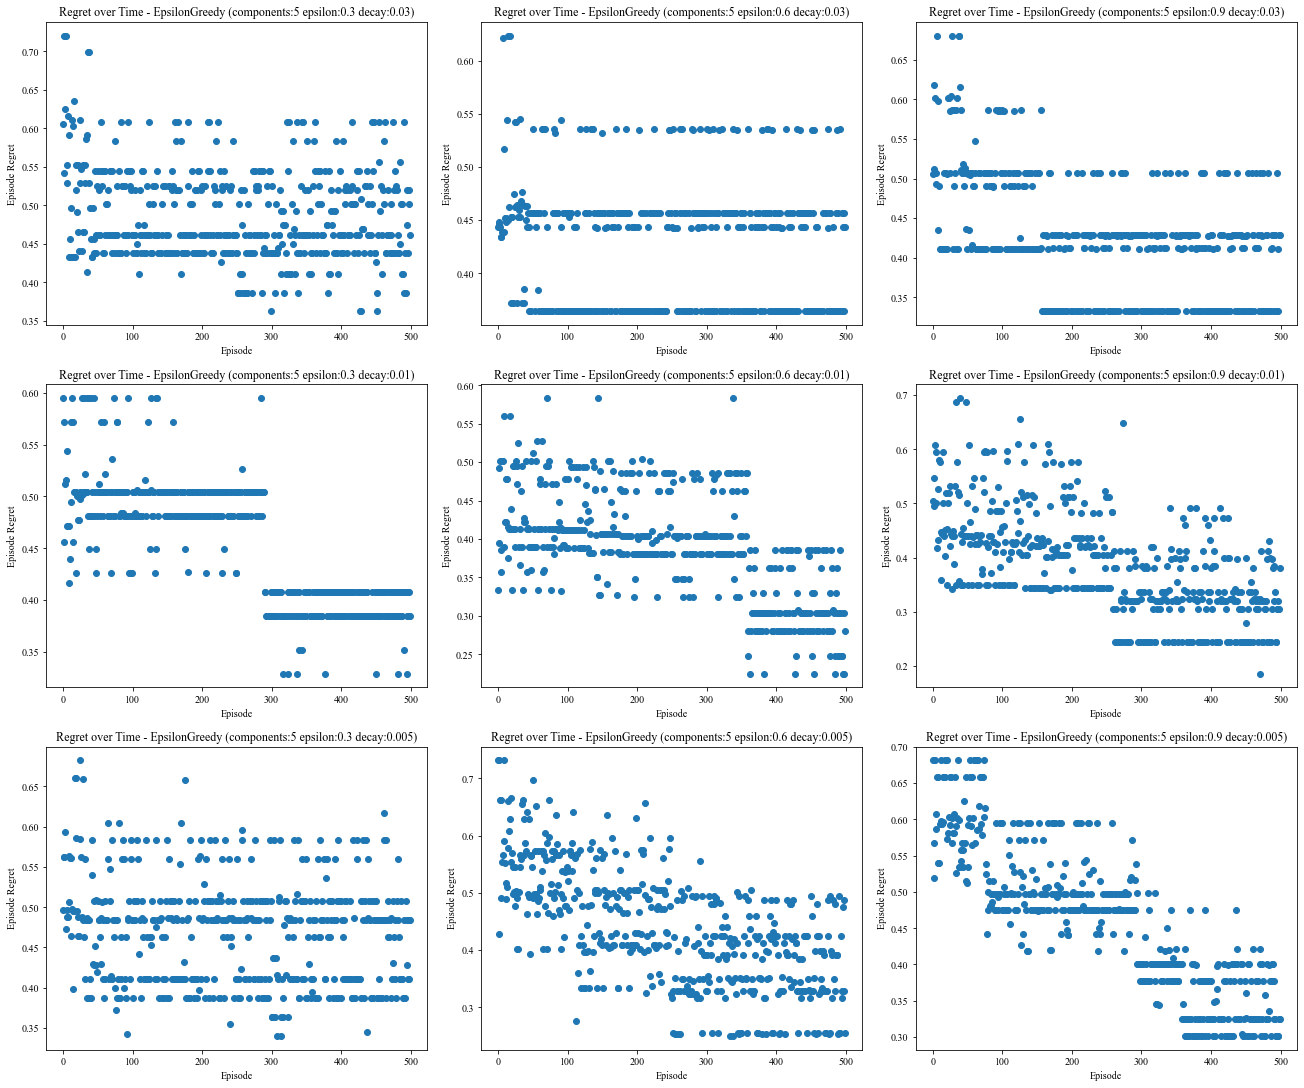

In [6]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='LinearShifted')
algos = [
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.03), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.03), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.03),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.01),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.005), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.005), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.005)
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='eGreedy_3x3_5components_LinearShifted')
exp.execute()
exp.save()
exp.plot(3, 'Regret')

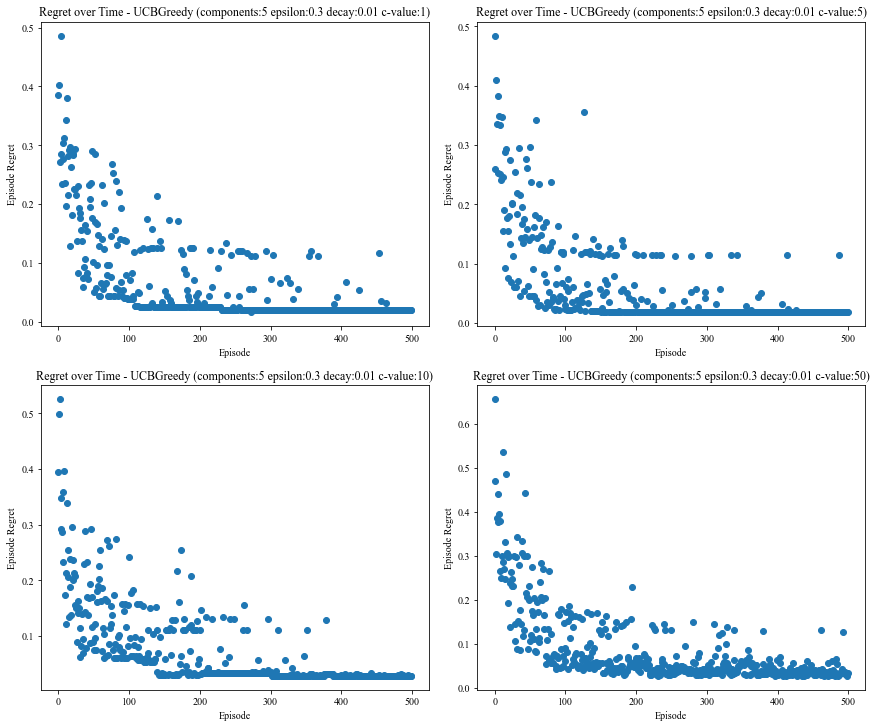

In [7]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='LinearShifted')
algos = [
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=1), 
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=5), 
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=10),
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=50),
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='UCBGreedy_2x2_5components__LinearShifted')
exp.execute()
exp.save()
exp.plot(2, 'Regret')

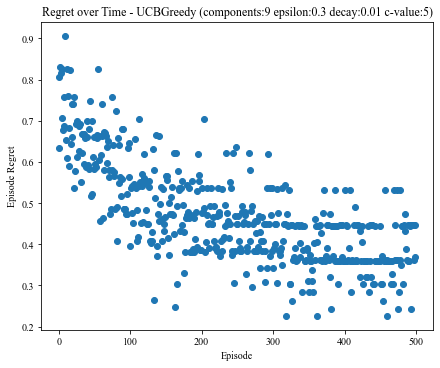

In [43]:
my_bandit = MultiArmedBandit(no_of_actions=9, transform='raw', env='LinearShifted')
algos = [
    #ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=5)
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='UCB_10trials_comp9_e03_d001_c_5_linearshifted')
exp.execute()
exp.save()
exp.plot(1, 'Regret')

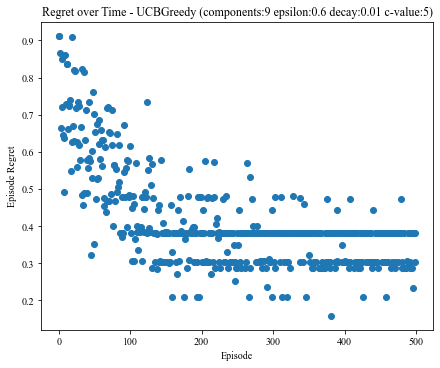

In [44]:
my_bandit = MultiArmedBandit(no_of_actions=9, transform='raw', env='LinearShifted')
algos = [
    #ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    UCBGreedy(my_bandit, epsilon=0.6, decay=0.01, c_value=5)
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='UCB_10trials_comp9_e06_d001_c_5_linearshifted')
exp.execute()
exp.save()
exp.plot(1, 'Regret')

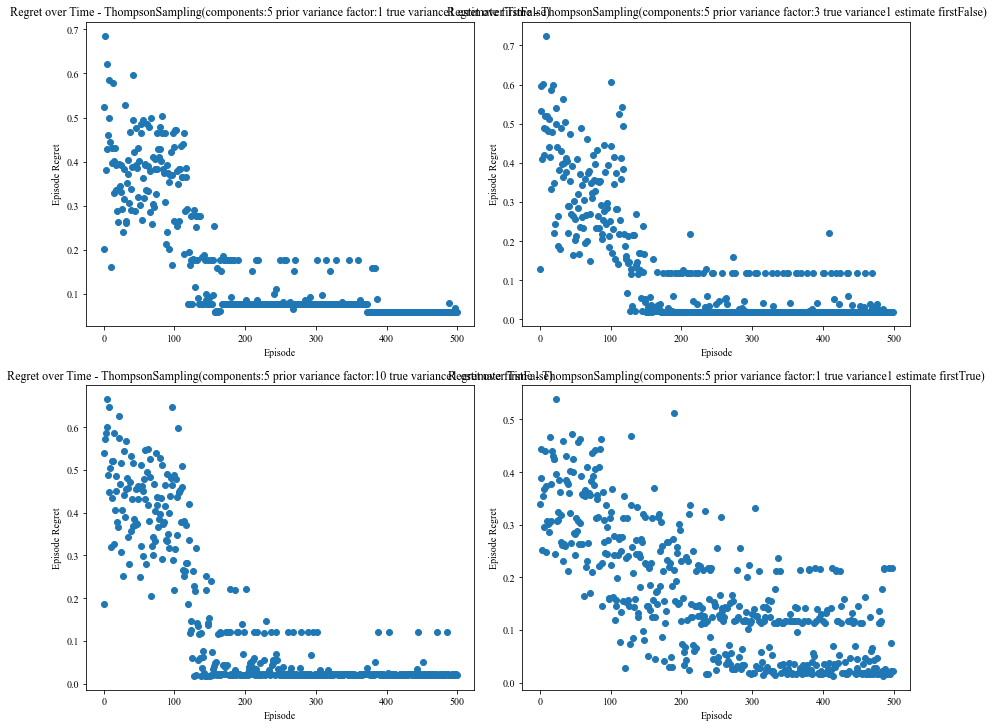

In [18]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='LinearShifted')
algos = [
    ThompsonSampling(my_bandit, prior_variance_factor=1, estimate_first=False), 
    ThompsonSampling(my_bandit, prior_variance_factor=3, estimate_first=False),
    ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    ThompsonSampling(my_bandit, estimate_first=True), 
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='Thompson_2x2_5components_LinearShifted')
exp.execute()
exp.save()
exp.plot(2, 'Regret')

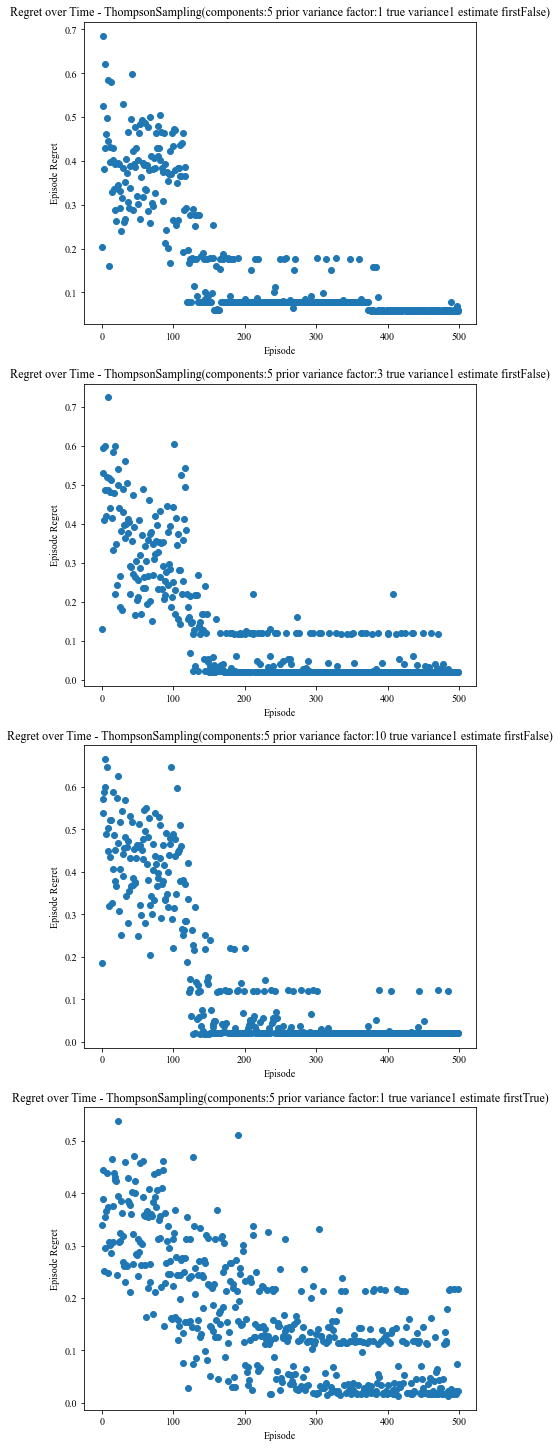

In [44]:

exp20 = pickle.load(open("experiment-Thompson_2x2_5components_LinearShifted.p", "rb"))
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='LinearShifted')
algos = [
    ThompsonSampling(my_bandit, prior_variance_factor=1, estimate_first=False), 
    ThompsonSampling(my_bandit, prior_variance_factor=3, estimate_first=False),
    ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    ThompsonSampling(my_bandit, estimate_first=True), 
]
exp21 = Experiment(algos, trials=10, iterations=500, exp_id='Thompson_2x2_5components_LinearShifted')
exp21.averaged_datasets = exp20.averaged_datasets
exp21.datasets = exp20.datasets
exp21._Experiment__algorithms = exp20._Experiment__algorithms
exp21.plot(1, 'Regret')


## Experiments GARCH

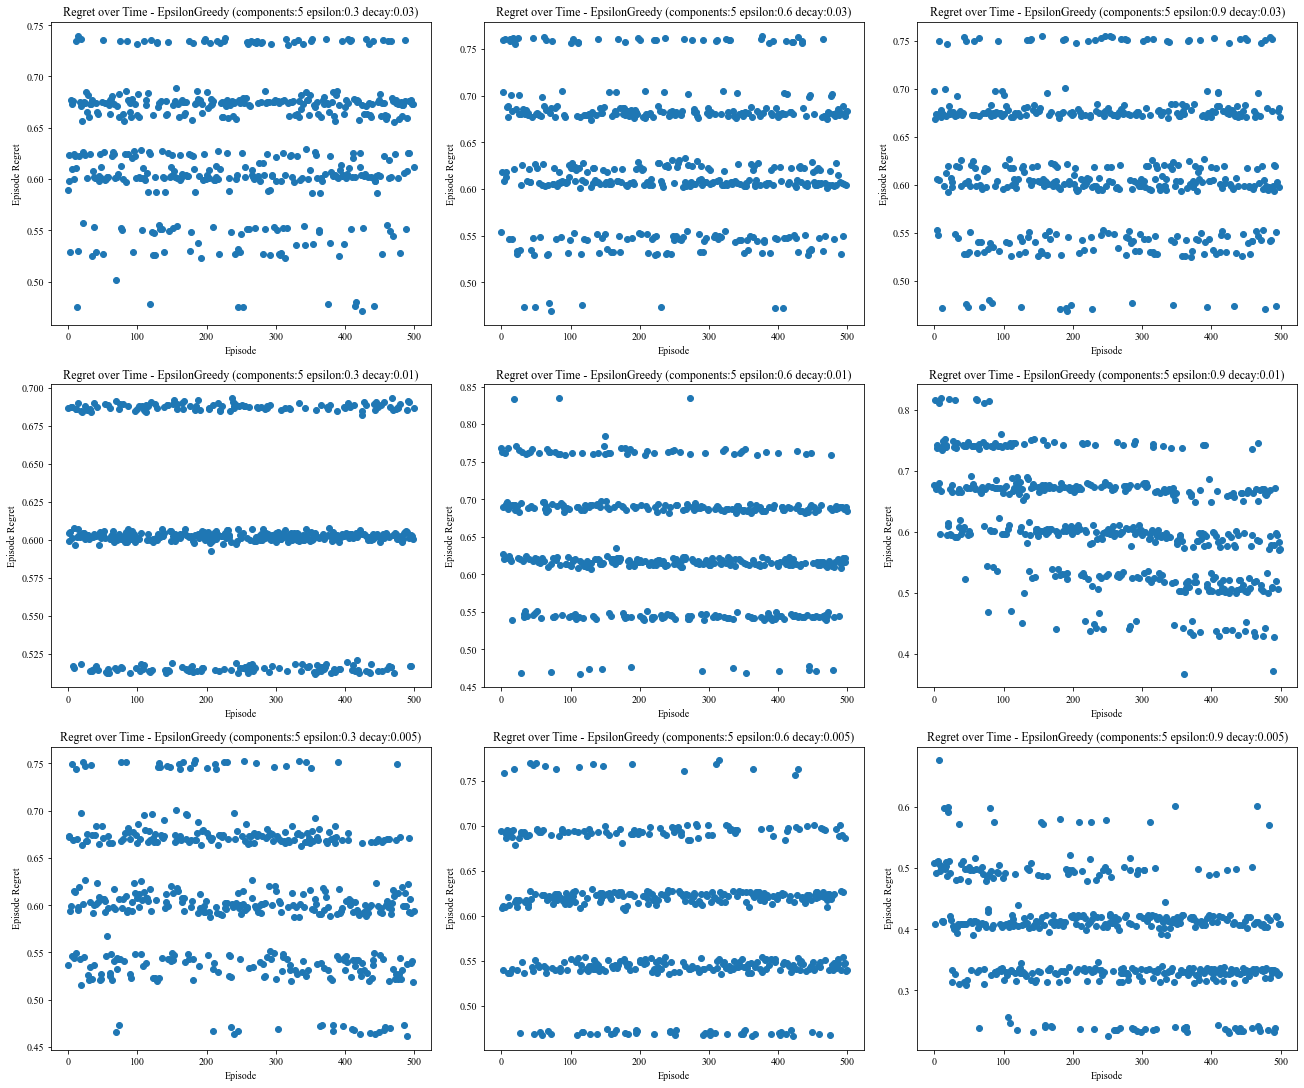

In [6]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='GARCH')
algos = [
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.03), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.03), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.03),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.01),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.005), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.005), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.005)
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='eGreedy_3x3_5components_GARCH')
exp.execute()
exp.save()
exp.plot(3, 'Regret')

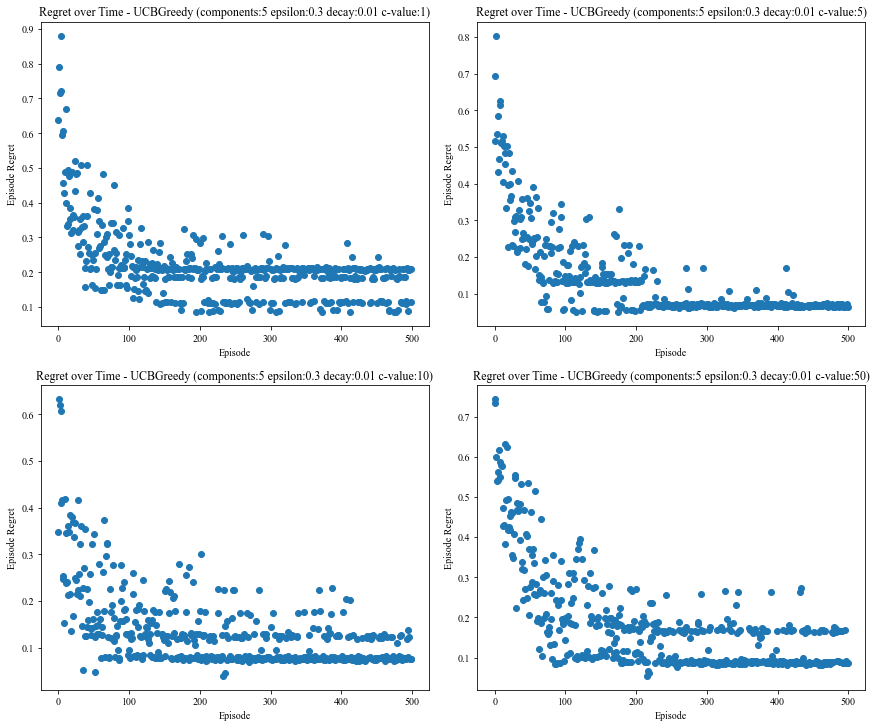

In [7]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='GARCH')
algos = [
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=1), 
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=5), 
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=10),
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=50),
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='UCBGreedy_2x2_5components_GARCH')
exp.execute()
exp.save()
exp.plot(2, 'Regret')

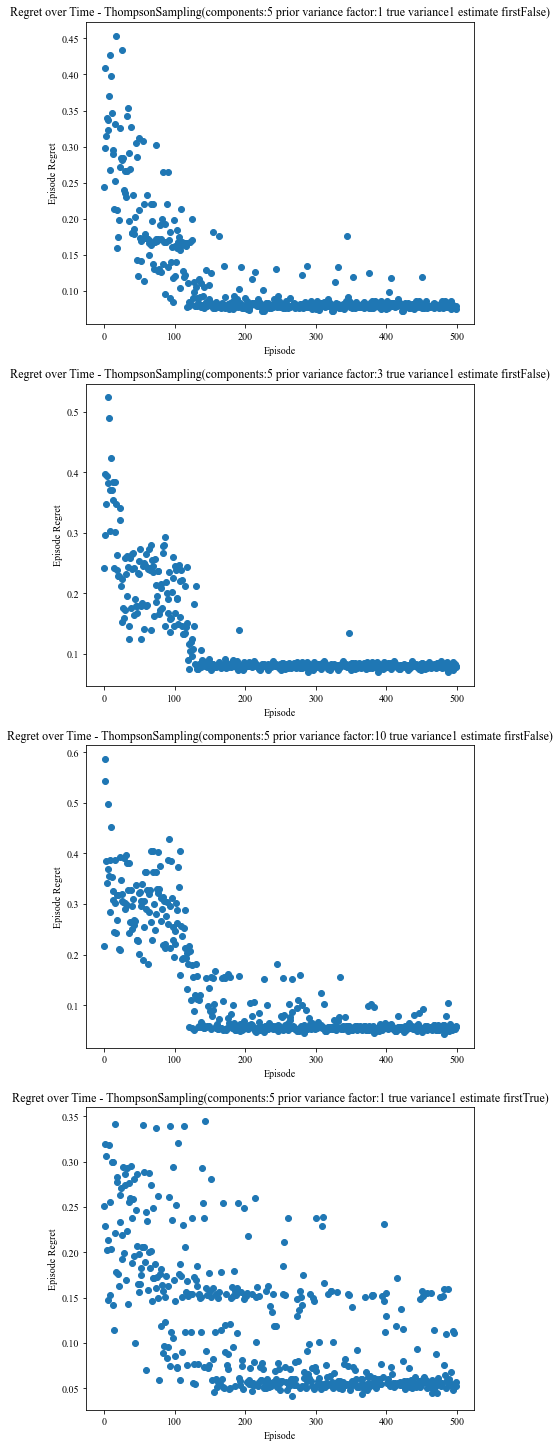

In [7]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='GARCH')
algos = [
    ThompsonSampling(my_bandit, prior_variance_factor=1, estimate_first=False), 
    ThompsonSampling(my_bandit, prior_variance_factor=3, estimate_first=False),
    ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    ThompsonSampling(my_bandit, estimate_first=True), 
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='Thompson_2x2_5components_GARCH')
exp.execute()
exp.save()
exp.plot(1, 'Regret')

## Experiments ARol

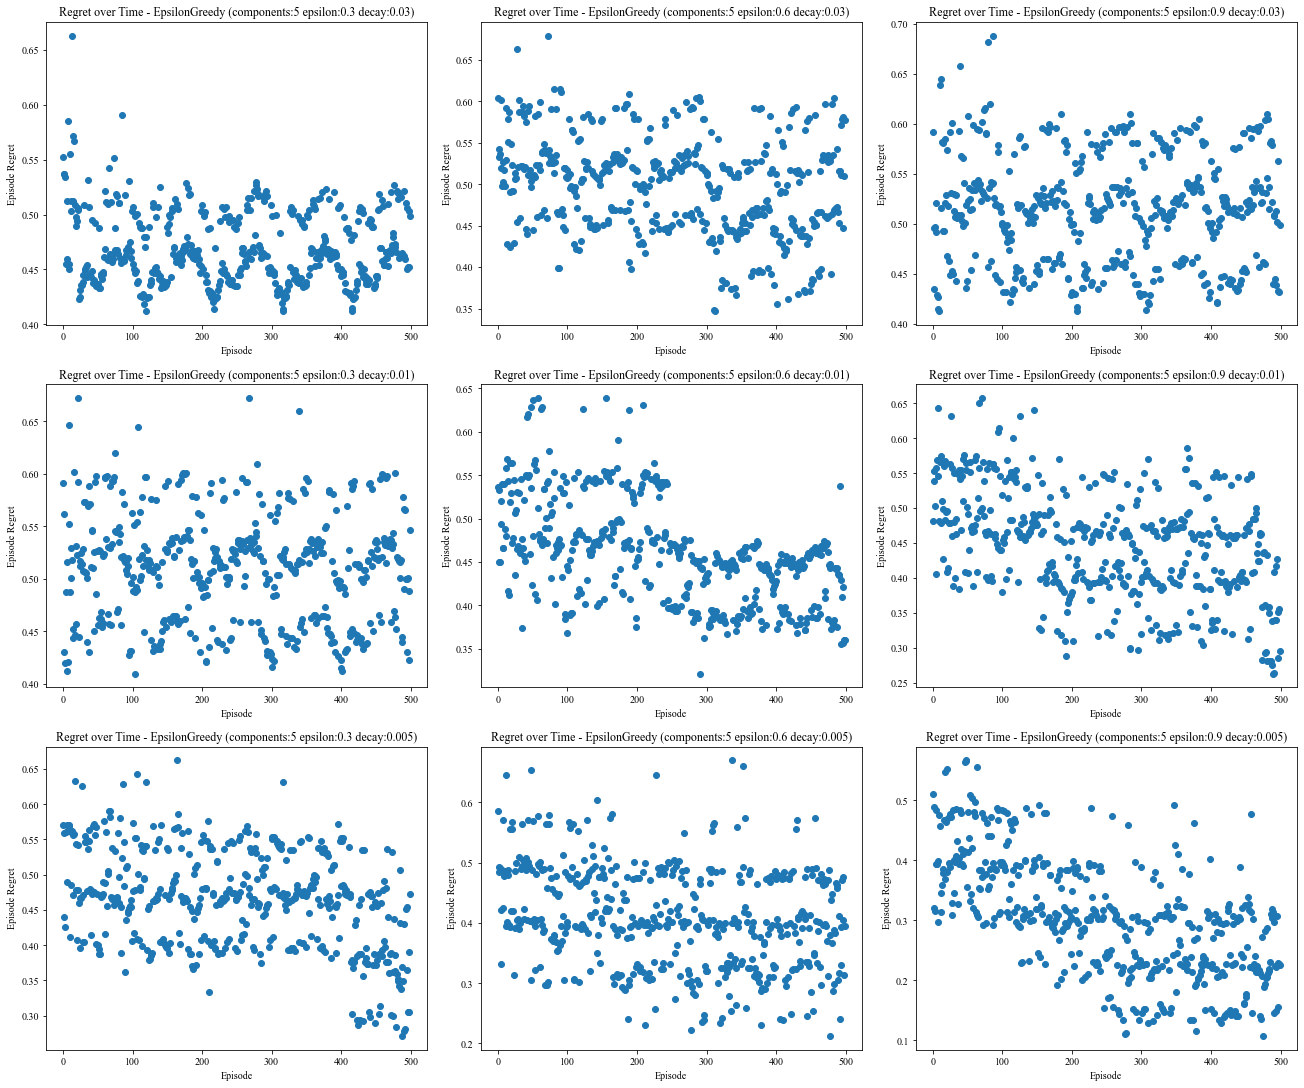

In [12]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='ARol')
algos = [
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.03), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.03), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.03),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.01),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.005), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.005), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.005)
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='eGreedy_3x3_5components_ARol')
exp.execute()
exp.save()
exp.plot(3, 'Regret')

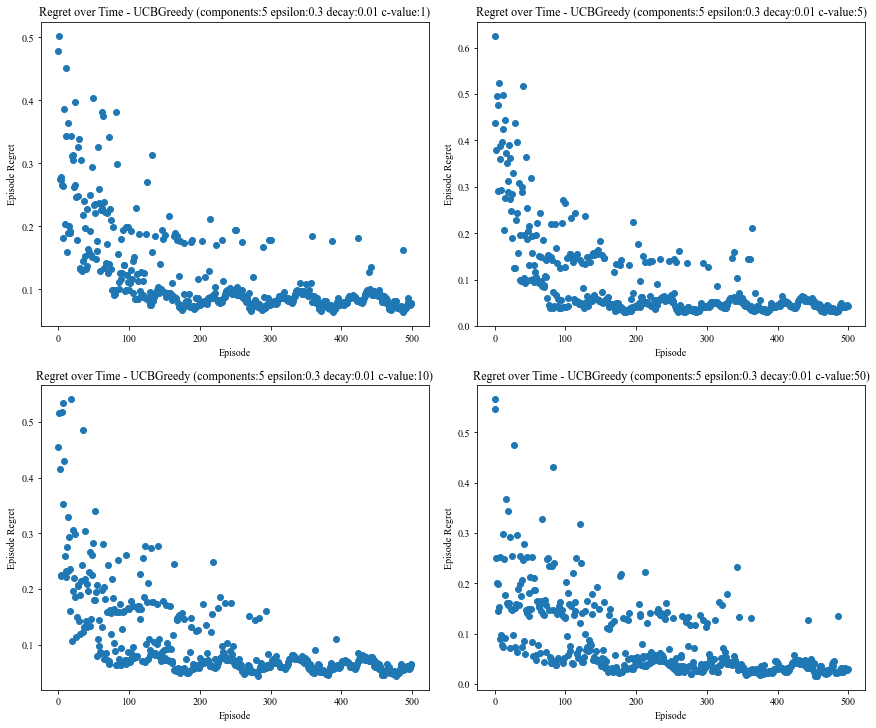

In [13]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='ARol')
algos = [
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=1), 
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=5), 
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=10),
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=50),
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='UCBGreedy_2x2_5components_ARol')
exp.execute()
exp.save()
exp.plot(2, 'Regret')

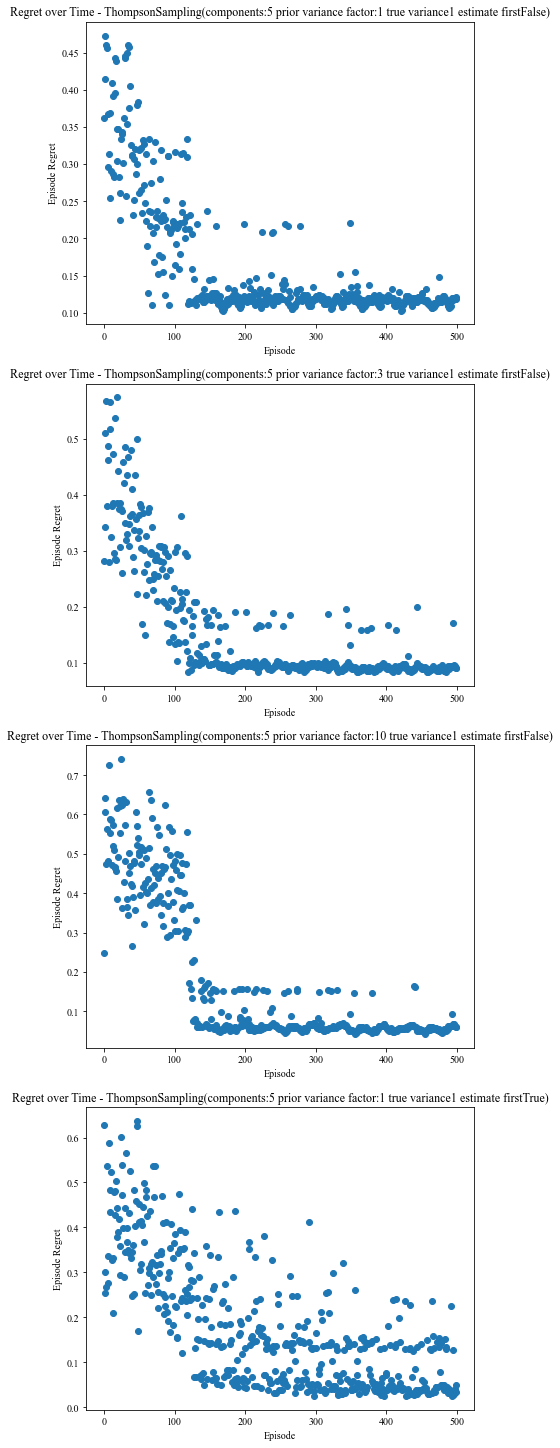

In [8]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='ARol')
algos = [
    ThompsonSampling(my_bandit, prior_variance_factor=1, estimate_first=False), 
    ThompsonSampling(my_bandit, prior_variance_factor=3, estimate_first=False),
    ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    ThompsonSampling(my_bandit, estimate_first=True), 
]
exp = Experiment(algos, trials=10, iterations=500, exp_id='Thompson_2x2_5components_ARol')
exp.execute()
exp.save()
exp.plot(1, 'Regret')

## Benchmark Experiment

In [28]:
len(BROKEN_COMPONENTS[3])

9

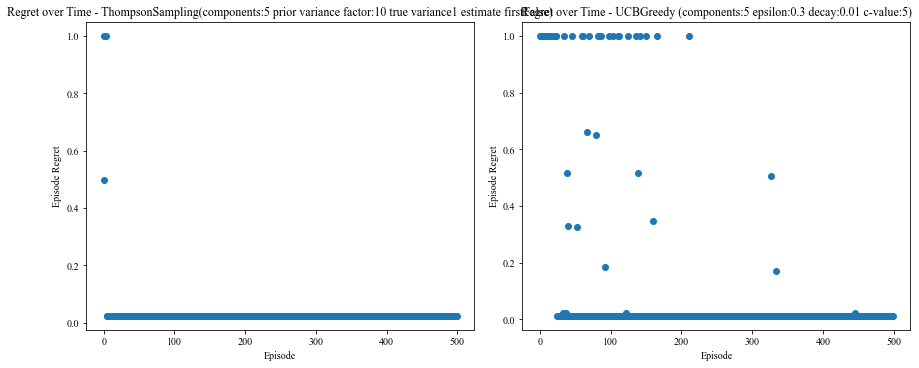

In [31]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='LinearShifted')
my_bandit.actions = BROKEN_COMPONENTS[1]
algos = [
    ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=5)
]
exp = Experiment(algos, trials=1, iterations=500, exp_id='UCB&Thompson_benchmark_comp5_linearshifted')
exp.execute()
exp.save()
exp.plot(2, 'Regret')

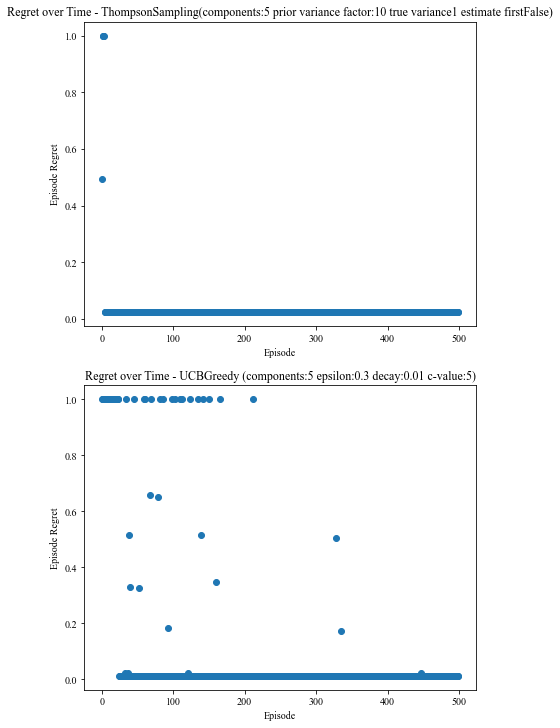

In [36]:
exp_bench5_1trial = pickle.load(open('experiment-UCB&Thompson_benchmark_comp5_linearshifted.p', 'rb'))
exp_bench5_1trial.plot(1, 'Regret')

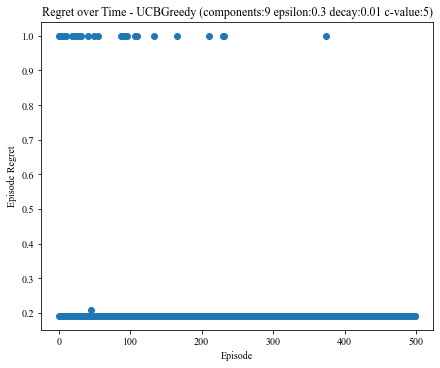

In [42]:
my_bandit = MultiArmedBandit(no_of_actions=9, transform='raw', env='LinearShifted')
my_bandit.actions = BROKEN_COMPONENTS[3]
algos = [
    #ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    UCBGreedy(my_bandit, epsilon=0.3, decay=0.01, c_value=5)
]
exp = Experiment(algos, trials=1, iterations=500, exp_id='UCB&Thompson_benchmark_comp9_e03_d001_c_5_linearshifted')
exp.execute()
exp.save()
exp.plot(1, 'Regret')

In [ ]:
my_bandit = MultiArmedBandit(no_of_actions=9, transform='raw', env='LinearShifted')
my_bandit.actions = BROKEN_COMPONENTS[3]
algos = [
    #ThompsonSampling(my_bandit, prior_variance_factor=10, estimate_first=False),  
    UCBGreedy(my_bandit, epsilon=0.6, decay=0.01, c_value=5)
]
exp = Experiment(algos, trials=1, iterations=500, exp_id='UCB&Thompson_benchmark_comp9_e06_d001_c_5_linearshifted')
exp.execute()
exp.save()
exp.plot(1, 'Regret')

#  ~~Old Experiments (not really relevant)~~

### Simulations

In [ ]:
my_bandit = MultiArmedBandit(no_of_actions=5, transform='raw', env='LinearShifted')
algos = [EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.01), UCBGreedy(my_bandit, epsilon=0.3, decay=0.01), ThompsonSampling(my_bandit)] #eol
sim = Simulator(algos)
sim.simulate(iterations=500, step_size=10)
sim.plot('optimal_arm_used')
sim.plot('regret')
sim.plot('reward')

In [143]:
my_bandit = MultiArmedBandit(no_of_actions=6, transform='raw', env='LinearShifted')
algos = [ThompsonSampling(my_bandit)] #eol
sim = Simulator(algos)
sim.simulate(iterations=1000, step_size=1)
sim.plot('optimal_arm_used')
sim.plot('regret')
sim.plot('reward')


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

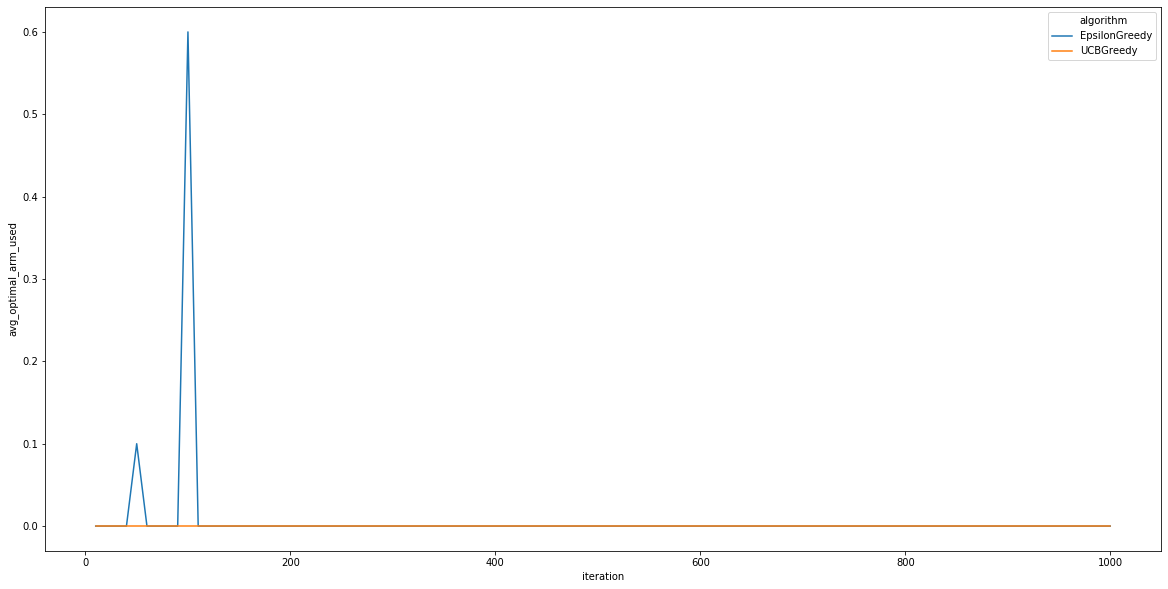

<Figure size 432x288 with 0 Axes>

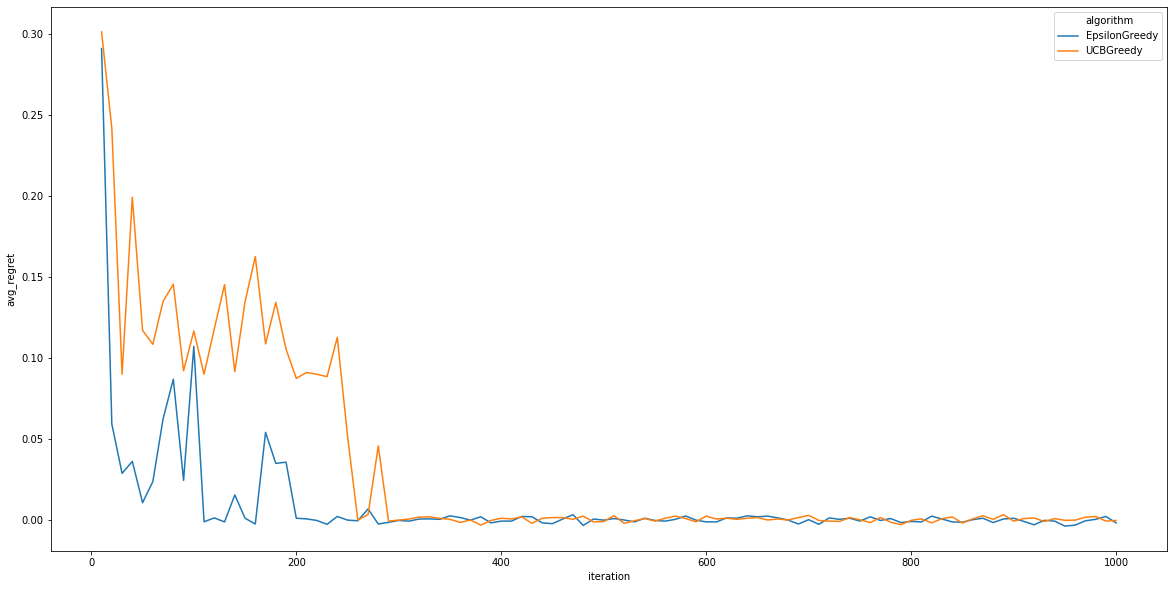

<Figure size 432x288 with 0 Axes>

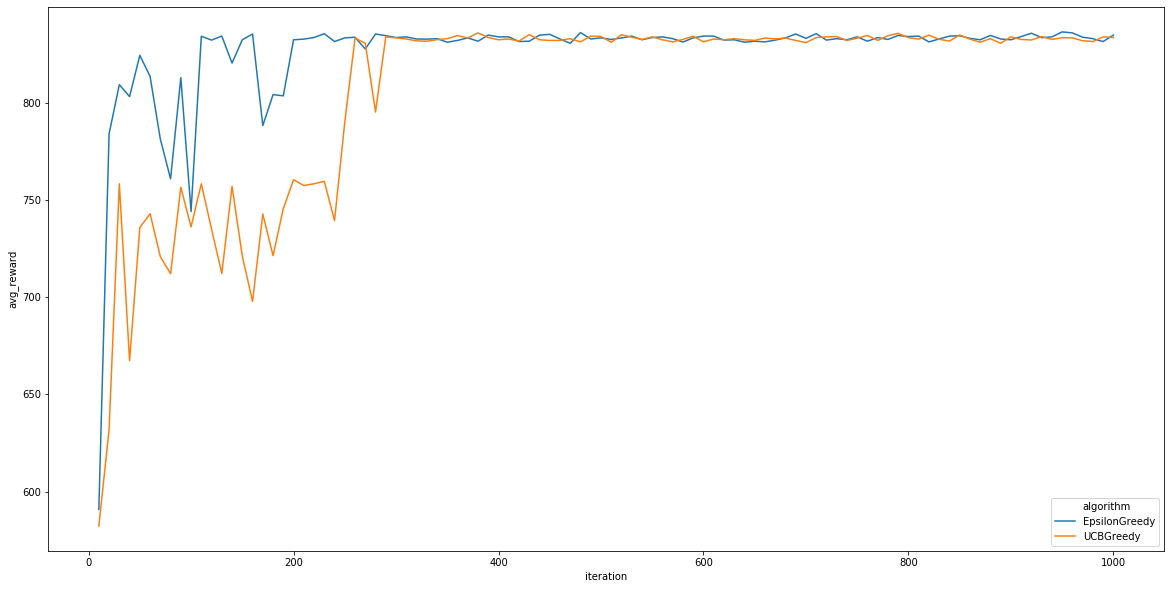

In [110]:
my_bandit = MultiArmedBandit(no_of_actions=4, transform='cube', env='Linear_Shifted')
algos = [
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.0), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.0), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.0),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.01), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.01),
    EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.001), EpsilonGreedy(my_bandit, epsilon=0.6, decay=0.001), EpsilonGreedy(my_bandit, epsilon=0.9, decay=0.001),
]
sim = Simulator(algos)
sim.simulate(iterations=1000, step_size=10)
sim.plot('optimal_arm_used')
sim.plot('regret')
sim.plot('reward')

In [109]:
algos[1].reward_regret_optimal()

(160.47248854627418, 0.0, False)

### Old Bandit Statistics

In [ ]:
class MultiArmedGambler:
    def __init__(self, bandit):
        self.bandit = bandit
        
    def distribution(self, pulls_each=100 ):
        my_distr = []
        for arm_index in range(self.bandit.number_of_arms):
            my_distr.append(self.distribution_for_arm(arm_index, pulls_each))
        return my_distr
            
    def distribution_for_arm(self, arm_index, pulls=100):
        arm_distr = []
        for i in range(pulls):
            arm_distr.append(self.bandit.pull_arm(arm_index))
        return arm_distr
        
    def plot_arm(self, arm, pulls=100, bin_width=100):
        distribution = self.distribution_for_arm(arm, pulls)
        number_of_bins = math.ceil((max(distribution) - min(distribution)) / bin_width)
        pyplot.figure()
        pyplot.subplots(figsize=(20, 10))
        seaborn.distplot(distribution, number_of_bins, norm_hist=False)
        pyplot.show()
        stats = (f"Mean: {mean(distribution)}; "
                 f"Median: {median(distribution)}; "
                 f"Mode: {mode(distribution)[0][0]}; "
                 f"Standard Deviation: {std(distribution)}; "
                 f"kurtosis: {kurtosis(distribution)}; "
                 f"Skewness: {skew(distribution)}")
        print(stats)
    
    def plot_all_arms(self, pulls_each=100, bin_width=100):
        for arm in range(self.bandit.number_of_arms):
            self.plot_arm(arm, pulls_each, bin_width)
        
    def log(self):
        return {arm: [] for arm in self.bandit.arms}
    
    def __rmse(self, target, estimate):
        target = np.array([target]).flatten()
        estimate = np.array([estimate]).flatten()
        assert(len(target) == len(estimate))
        new_target = np.array([target[i] for i in range(len(target)) if not (math.isnan(target[i]) or math.isnan(estimate[i]))])
        new_estimate = np.array([estimate[i] for i in range(len(estimate)) if not (math.isnan(target[i]) or math.isnan(estimate[i]))])
        return np.sqrt(((new_target - new_estimate) **2).mean())
        
        
    def epsilon_greedy(self, epsilon=0.3, decay=0.0, stopping_rule=0.05, use_ucb=False, max_iterations=3000):
        params = {"epsilon": epsilon, "decay": decay, "stopping_rule": stopping_rule, "use_ucb": use_ucb, "max_iterations": max_iterations}
        random.seed()
        log = [[] for arm in self.bandit.arms]
        rmse_log = []
        optimal_arm = random.randrange(len(log))
        true_optimal_arm = self.bandit.true_optimal_arm
        log[optimal_arm].append(self.bandit.pull_arm(optimal_arm))
        iteration = 1
        means = [statistics.mean(entry) if entry else 0 for entry in log]
        upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(log[index])) if log[index] else means[index] for index in range(len(means))]
        
        def print_iteration():
            print(f"rmse: {rmse}")
            print(f"means: {means}")
            print(f"max mean: {max(means)}")
            print(f"true means: {self.bandit.true_mean_arm_rewards}")
            print(f"epsilon: {epsilon}")
            print(f"...iteration {iteration}")
            print("__________________________________________________")
        
        def plot_rmse():
            pyplot.figure()
            pyplot.subplots(figsize=(20, 10))
            seaborn.lineplot(data=pd.DataFrame(rmse_log), dashes=False)
            pyplot.show()
            print(f"True optimal arm: arm{true_optimal_arm} with true mean reward: {self.bandit.true_mean_arm_rewards[true_optimal_arm]}")
            print(f"Estimated optimal arm: arm{optimal_arm} with estimated mean reward: {np.array(log[optimal_arm]).mean()}")
        
        while ((iteration <= max_iterations) and self.__rmse(self.bandit.true_mean_arm_rewards, means) > stopping_rule * np.array(self.bandit.true_mean_arm_rewards).mean()):
            if random.random() <= epsilon:
                random_arm = random.randrange(len(log))
                log[random_arm].append(self.bandit.pull_arm(random_arm))
                print(f"chosen arm (random): arm{random_arm}")
            else:
                log[optimal_arm].append(self.bandit.pull_arm(optimal_arm))
                print(f"chosen arm (optimal): arm{optimal_arm}")
            means = [statistics.mean(entry) if entry else 0 for entry in log]
            upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(log[index])) if log[index] else means[index] for index in range(len(means))]
            optimal_arm = upper_confidence_bounds.index(max(upper_confidence_bounds)) if use_ucb else means.index(max(means))
            epsilon = epsilon * (1-decay)
            rmse = {f"Arm{arm_index}": (self.__rmse(self.bandit.true_mean_arm_rewards[arm_index], means[arm_index]) / self.bandit.true_mean_arm_rewards[arm_index]) for arm_index in range(len(log))}
            rmse["RMSE"] = self.__rmse(self.bandit.true_mean_arm_rewards, means) / np.array(self.bandit.true_mean_arm_rewards).mean()
            rmse_log.append(rmse)
            iteration += 1
            if iteration % 20 == 0:
                plot_rmse()
            print_iteration()
            
            
        plot_rmse()
        print_iteration()
        
        percentage_optimal_arm = len(log[self.bandit.true_optimal_arm])/iteration
        observed_reward = 0
        for arm_index in range(len(log)):
            observed_reward += self.bandit.true_mean_arm_rewards[arm_index] * len(log[arm_index])
        true_reward = self.bandit.true_mean_arm_rewards[self.bandit.true_optimal_arm] * iteration
        regret = true_reward - observed_reward
        average_regret = regret/iteration
        
        return {'iterations': iteration, 'rmse': rmse_log[-1]['RMSE'], 'reward': np.array(log).sum(), 'epsilon': epsilon, 'log': log, 'rmse_log':rmse_log, 'params': params, 'percentage_optimal_arm_used': percentage_optimal_arm, 'regret': regret, 'average regret': average_regret}
      


def evaluate_trial(trial, gambler):
    percentage_optimal_arm = len(trial['log'][gambler.bandit.true_optimal_arm])/trial['iterations']
    observed_reward = 0
    for arm_index in range(len(trial['log'])):
        observed_reward += gambler.bandit.true_mean_arm_rewards[arm_index] * len(trial['log'][arm_index])
    true_reward = gambler.bandit.true_mean_arm_rewards[gambler.bandit.true_optimal_arm] * trial['iterations']
    regret = true_reward - observed_reward
    average_regret = regret/trial['iterations']
    return {'percentage_optimal_arm_used': percentage_optimal_arm, 'regret': regret, 'average regret': average_regret}


three_actions = (('Query Service', 'CF1', 'RestartComponent'), 
                 ('Authentication Service', 'CF3', 'ReplaceComponent'), 
                 ('Reputation Service', 'CF5', 'AddReplica'))

actions = (('Query Service', 'CF1', 'RestartComponent'), 
          ('Authentication Service', 'CF3', 'ReplaceComponent'), 
          ('Reputation Service', 'CF5', 'AddReplica'), 
          ('Item Management Service', 'CF5', 'AddReplica'), 
          ('Last Second Sales Item Filter', 'CF2', 'RestartComponent'))
my_bandit = MultiArmedBandit(three_actions, data)
my_gambler = MultiArmedGambler(my_bandit)

### A Bit of Gambling

In [ ]:
my_gambler.plot_all_arms()

print(my_bandit.true_mean_arm_rewards)

In [ ]:
epsilon_greedy_trials = []
ucb_trials = []
hyperparams = [
    {'epsilon': 0.9, 'decay': 0.0, },
    {'epsilon': 0.9, 'decay': 0.001, },
    {'epsilon': 0.9, 'decay': 0.01, },
    {'epsilon': 0.6, 'decay': 0.0, },
    {'epsilon': 0.6, 'decay': 0.001, },
    {'epsilon': 0.6, 'decay': 0.01, },
    {'epsilon': 0.3, 'decay': 0.0, },
    {'epsilon': 0.3, 'decay': 0.001, },
    {'epsilon': 0.3, 'decay': 0.01, }
]
for params in hyperparams:
    ucb_trials.append(my_gambler.epsilon_greedy(epsilon=params['epsilon'], decay=params['decay'], use_ucb=True))
    
for params in hyperparams:
    epsilon_greedy_trials.append(my_gambler.epsilon_greedy(epsilon=params['epsilon'], decay=params['decay']))

In [ ]:
pickle.dump(ucb_trials, open('ucb_trials.p', 'wb'))
pickle.dump(epsilon_greedy_trials, open('epsilon_greedy_trials.p', 'wb'))